In [1]:
# from IPython.display import display, HTML
# from IPython.display import display, HTML
# from ipywidgets import interact, widgets
# %matplotlib notebook

# %matplotlib ipympl
%matplotlib widget

import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py


# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


print(os.getpid())
%cd ../../

import pylib.mix as mix

15288
C:\Users\ivan9\Documents\work\codes\QuCF\scripts-py


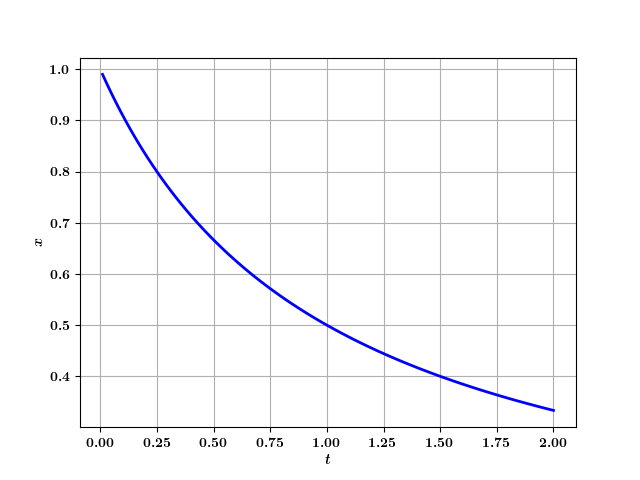

In [2]:
# ----------------------------------------------
# --- Solve d x / d t = - x**2 ---
# ----------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

t_end = 2
min_dt = 0.01
max_dt = 0.02
Nt_max = int(t_end/min_dt)
x0 = np.array([1,2])

yy = lambda t,x: -x**2

oo = RK45(yy, 0, x0, t_end, first_step=min_dt, max_step=max_dt)

res_x   = np.array([None]*Nt_max,dtype=float)
t_array = np.array([None]*Nt_max,dtype=float)
Nt_act = 0
while mix.compare_two_strings(oo.status, "running"):
    oo.step()
    res_x[Nt_act]   = float(oo.y[0])
    t_array[Nt_act] = float(oo.t)
    # print("res = ", res_x[Nt_act], " at t = {:0.3f}".format(t_array[Nt_act]))
    Nt_act += 1
res_x   = res_x[:Nt_act]
t_array = t_array[:Nt_act]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_array, res_x, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$t$')
plt.ylabel("$x$")
# ax.legend()
plt.grid(True)
plt.show()

In [25]:
from scipy.integrate import RK45
mix.reload_module(mix)

t_end = 2
x0 = np.array([1,2])

yy = lambda t,x: -x**2

oo = RK45(yy, 0, x0, t_end, first_step=0.01)

while mix.compare_two_strings(oo.status, "running"):
    oo.step()
    print("res = ", oo.y, " at t = {:0.3f}".format(oo.t))

res =  [0.99  1.961]  at t = 0.010
res =  [0.901 1.639]  at t = 0.110
res =  [0.693 1.063]  at t = 0.444
res =  [0.533 0.728]  at t = 0.877
res =  [0.395 0.493]  at t = 1.533
res =  [0.333 0.401]  at t = 2.000


In [30]:
8//3

2